# Resolução do Case Manutenção Preditiva

# Definição do problema

Antes de começar as análises, é necessário entender a fundo o dataset que temos e o problema de negócio apresentado. A manutenção preditiva é, conceitualmente falando, a detecção de tendências e padrões de parâmetros de máquinas que geram uma falha conhecida, como uma curva característica de pressão interna, um range específico de torque do motor, entre outros exemplos.

No dataset apresentado, a variável de previsão apresenta 5 modos de falha distintos, que são trazidos na coluna 'failure_type', com os modos de falha devidamente explicados no dicionário de dados.

Dito isso, entende-se que o problema apresentado é um problema de classificação, já que estamos diante de variáveis categóricas nominais (não existe ordenação dentro das categorias). Para análises posteriores, entende-se a necessidade de criação de uma coluna auxiliar 'machine_failure' com valores boolianos (sim/não), que marque os registros que apresentem falha de máquinas.

Já nos é apresentado os datasets divididos em teste e treino, correspondendo a um total de 10000 registros. Primeiramente, analisa-se o dataframe obtido com a junção dos datasets de treino e de teste sem a feature de predição 'failure_type', para obter algumas noções de estatísticas descritivas e plotar alguns gráficos buscando insights iniciais e correlações/interações em nossas variáveis.

# Carregando os dados

In [1]:
import pandas as pd
import numpy as np

Importando bibliotecas para análise e manipulação dos dados

In [2]:
#Importando os arquivos e setando os dataframes 

filename_treino = 'C:\BKP CAIO\Indicium\Processo Seletivo\Case\desafio_manutencao_preditiva_treino.csv' #Favor, colocar o caminho do arquivo antes de rodar o projeto!!
filename_teste = 'C:\BKP CAIO\Indicium\Processo Seletivo\Case\desafio_manutencao_preditiva_teste.csv' #Favor, colocar o caminho do arquivo antes de rodar o projeto!!
df1 = pd.read_csv(filename_treino)
df2 = pd.read_csv(filename_teste)
df3 = pd.concat([df1, df2])
df = df3.drop(columns=['failure_type', 'udi'])


Obtendo o dataframe utilizado na análise exploratória

In [3]:
df.head()

,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,M14860,M,298.1,308.6,1551,42.8,0
1,L47181,L,298.2,308.7,1408,46.3,3
2,L47184,L,298.2,308.7,1408,40.0,9
3,M14865,M,298.1,308.6,1425,41.9,11
4,L47186,L,298.1,308.6,1558,42.4,14


# Análise exploratória dos dados

Obtendo informações iniciais acerca das features do dataframe

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 3332
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             10000 non-null  object 
 1   type                   10000 non-null  object 
 2   air_temperature_k      10000 non-null  float64
 3   process_temperature_k  10000 non-null  float64
 4   rotational_speed_rpm   10000 non-null  int64  
 5   torque_nm              10000 non-null  float64
 6   tool_wear_min          10000 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 625.0+ KB


Como não há dados nulos no dataframe, seguimos para verficação de outliers e valores únicos

In [5]:
df1.nunique() #df1 contém features preditores e a variável de predição

udi                      6667
product_id               6667
type                        3
air_temperature_k          93
process_temperature_k      82
rotational_speed_rpm      840
torque_nm                 547
tool_wear_min             243
failure_type                6
dtype: int64

Nessa etapa, utilizei o método '.nunique' para contagem de valores únicos do dataset. Isso foi feito para verificar se não existiam datapoints escritos errados (misspelling) nas features categóricas 'type' e na varíavel de predição 'failure_type', confirmando se as informações correspondiam ao trazido no dicionário de dados.

Após verificação de que os dados estão corretos, seguimos para algumas estatísticas descritivas.

In [6]:
df.describe().style.background_gradient() #Voltando ao dataset 'df' que contém apenas as features preditoras

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


Usei aqui o método "describe" para trazer algumas estatísticas descritivas básicas das features numéricas, para ter uma melhor noção dos dados antes de prosseguir. Observa-se as médias próximas entre as features 'air_temperature_k' e 'process_temperature_k', e ambas com baixo desvio padrão (processo controlado). 

Uma feature que se destaca é a 'tool_wear_min' com alto valor de desvio padrão, correspondendo mais da metade do valor da média. Isso, de pronta análise, já nos gera um alerta.

Tais constatações são importantes de se ter em mente antes da análise dos dados propriamente dita, objetivando a procura de interações das variáveis e o estudo do comportamento destas, já que o business case trata de um processo de manufatura, e as empresas buscam por processos estáveis e com confiabilidade.

Entende-se aqui, no jargão técnico da manutenção industrial, confiabilidade como o inverso do tempo médio entre falhas de máquinas, um indicador importante para determinação de cronograma de manutenções preventivas e na destinação de CapEx (Capital Expenditure), estando presente portanto em decisões de cunho estratégico do setor.

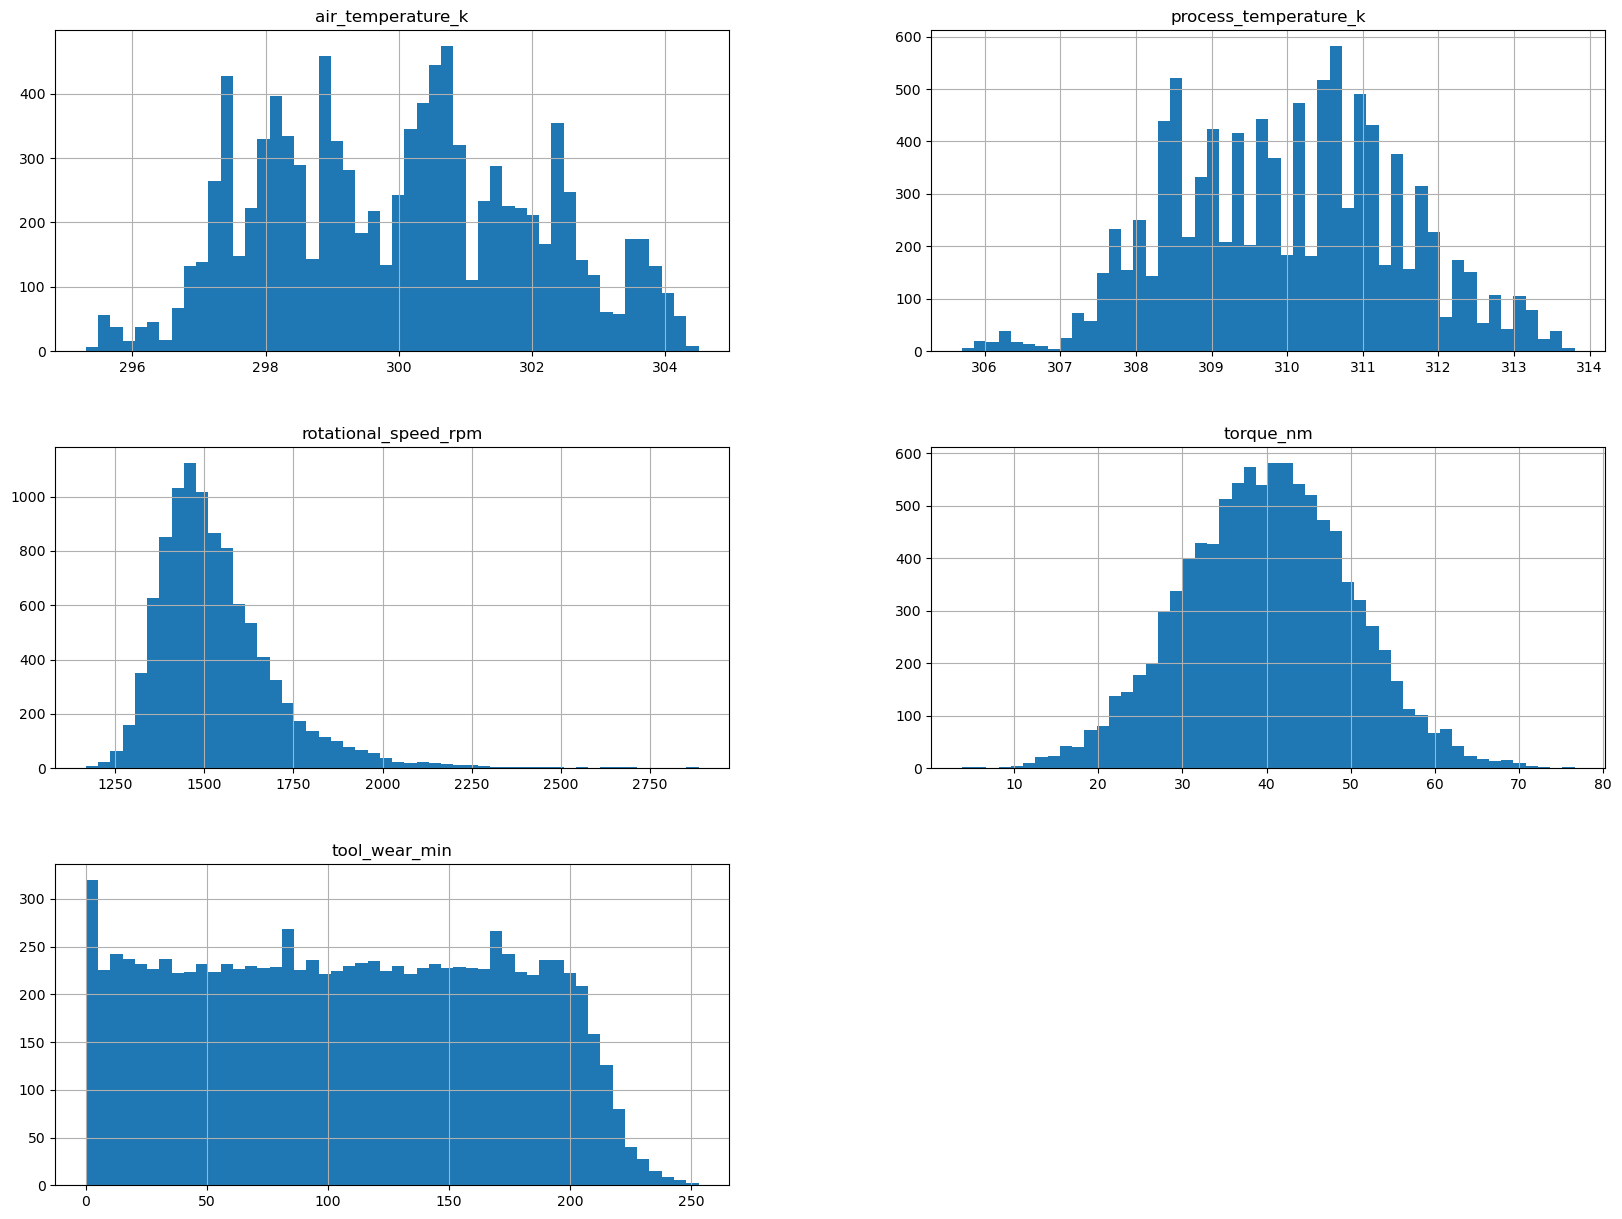

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50,figsize=(20,15))
plt.show()

Em seguida, plotei alguns histogramas para ter noção de como estão distribuídos os dados das features no dataset.

Esta etapa é apenas uma verificação: muitas das informações acerca das features já são encontradas no dicionários dos dados.

Entretanto, é interessante observar os padrões visuais quando plotamos um histograma pois a distribuição de frequências pode envidenciar outliers e, possivelmente, algum intervalo de interação entre as features. A presença de outliers e o estudo de correlação serão investigados no detalhe em etapas posteriores.

De primeira instância, já é possível observar:

-> Os dados apresentados de torque (feature 'torque_nm') apresentam um shape que sugere fortemente uma distribuição normal.

-> Para a feature 'tool_wear_min', observa-se uma concentração atípica dos dados no valor de 0. Os valores próximos de 250 min apresentam baixíssima frequência.

-> Para a feature 'rotational_speed_r' observa-se um shape de distribuição normal com leve distorção, como alegado no dicionário que essa feature apresenta um ruído normalmente distribuído acrescido aos valores.

-> Pela observação visual, a única feature que parece conter algum outlier seria a feature 'rotational_speed_rpm', e para a verificação deste fato será feito um boxplot logo em seguida.


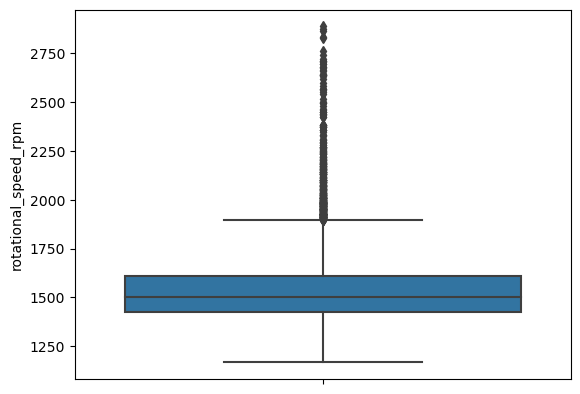

In [8]:
import seaborn as sns
sns.boxplot(y = df['rotational_speed_rpm']);
plt.show()

Como foi possível observar, essa feature apresenta alguns valores discrepantes (acima do limite superior), como já esperado de acordo com as infos trazidas no dicionário de dados. Esse é um sinal de alerta pois caso não haja convergência no modelo, os valores de outliers deverão ser tratados. Por enquanto, seguiremos com essa feature e reavaliaremos o caso, se houver necessidade.

# Correlação entre features

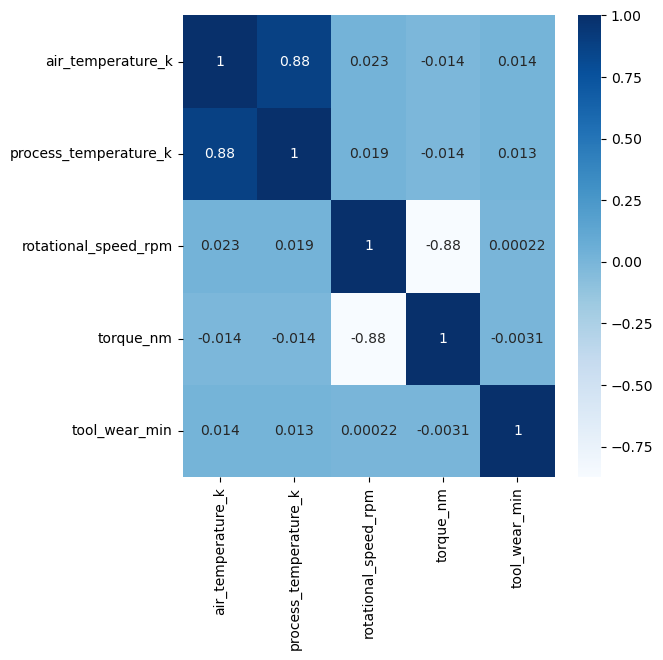

In [9]:
plt.figure (figsize = (6,6))
sns.heatmap(df.corr(),annot=True, cmap='Blues')
plt.show()

Ao fazer o gráfico de correlação entre as features obtemos alguns insights muito interessantes! 

Observa-se que a feature de temperatura do ar (air_temperature_k) relaciona-se fortemente com a feature de temperatura de processo (process_temperature_k) de maneira diretamente proporcional (valores próximos de 1): ou seja, significa que o aumento de uma implica no aumento de outra. 

Também podemos dizer que encontra-se forte correlação inversamente proporcional (valores próximos de -1) entre as variáveis de velocidade de rotação (rotacional_speed_rpm) com torque (torque_nm): o aumento de uma corresponde em uma diminuição da outra. Inclusive, de acordo com o dicionário de dados, existe um modo de falha específico atrelado ao produto dessas duas features: quando a potência for menor que 3500W ou maior que 9000W, o processo falha. É plausível levantar a hipótese que haja alguma interação entre essas variáveis com o resultado dos modos de falha apresentados. As outras variáveis não apresentam correlação significativas entre si (valores próximos de 0). 

A matriz de correlação nos traz informações quanto a linearidade das features, mas como esse problema não é de regressão linear e a relação das features com a variável de predição ainda não está totalmente clara, acredito que a melhor forma de se seguir para a seleção de feature seria, de fato, usar algum algortimo de feature selection.

In [10]:
df1["temperature_diference_k"] = df1["process_temperature_k"] - df1["air_temperature_k"]
df1['power_w'] = df1['torque_nm'] * (df1['rotational_speed_rpm']/9.5492965964254) #conversão de rpm para rad/s
df1['machine_failure'] = df1['failure_type'].apply(lambda x: 0 if x == 'No Failure' else 1)
df1.sample(15)

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,temperature_diference_k,power_w,machine_failure
3544,5309,L52488,L,304.0,313.2,1481,42.6,213,No Failure,9.2,6606.832175,0
519,770,L47949,L,296.9,308.0,1343,44.5,15,No Failure,11.1,6258.419078,0
3436,5149,L52328,L,304.4,313.6,1507,43.1,13,No Failure,9.2,6801.726111,0
4582,6880,H36293,H,300.8,311.2,2237,17.0,95,No Failure,10.4,3982.387563,0
5781,8667,L55846,L,297.5,308.7,1407,42.5,145,No Failure,11.2,6261.979550,0
1388,2075,L49254,L,299.5,309.4,1602,31.5,193,No Failure,9.9,5284.472997,0
714,1061,H30474,H,296.7,307.9,1424,53.8,133,No Failure,11.2,8022.706094,0
4577,6873,L54052,L,301.0,311.3,1472,35.3,73,No Failure,10.3,5441.406021,0
5395,8110,L55289,L,300.3,311.7,1821,26.3,202,No Failure,11.4,5015.269922,0
694,1034,H30447,H,296.4,307.5,1556,38.0,62,No Failure,11.1,6191.869674,0


Dando continuidade ao processo investigativo inicial, voltamos ao dataset de treino e faremos um scatterplot para cada feature numérica, ainda na procura da investigação de padrões visuais que corroborem as hipóteses inicialmente levantadas e que nos ajude no processo de seleção de features e treino do modelo.

Para esta etapa a coluna 'machine_failure' será criada para auxiliar na investigação de padrões visuais gráficos. Também foi criada a coluna auxiliar 'temperature_diference_k" e a 'power_k', ambas trazendo informações sobre os modos de falha apresentados no dicionário de dados.

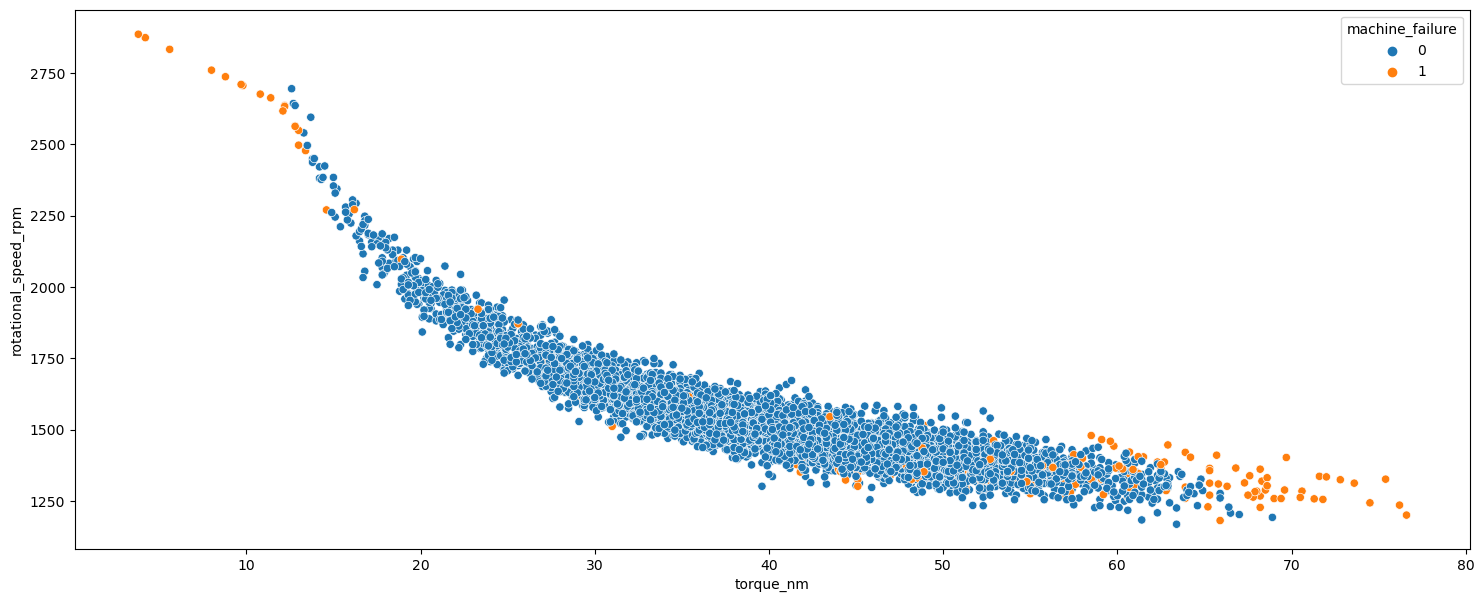

In [11]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=df1, x="torque_nm", y="rotational_speed_rpm", hue='machine_failure',palette="tab10");

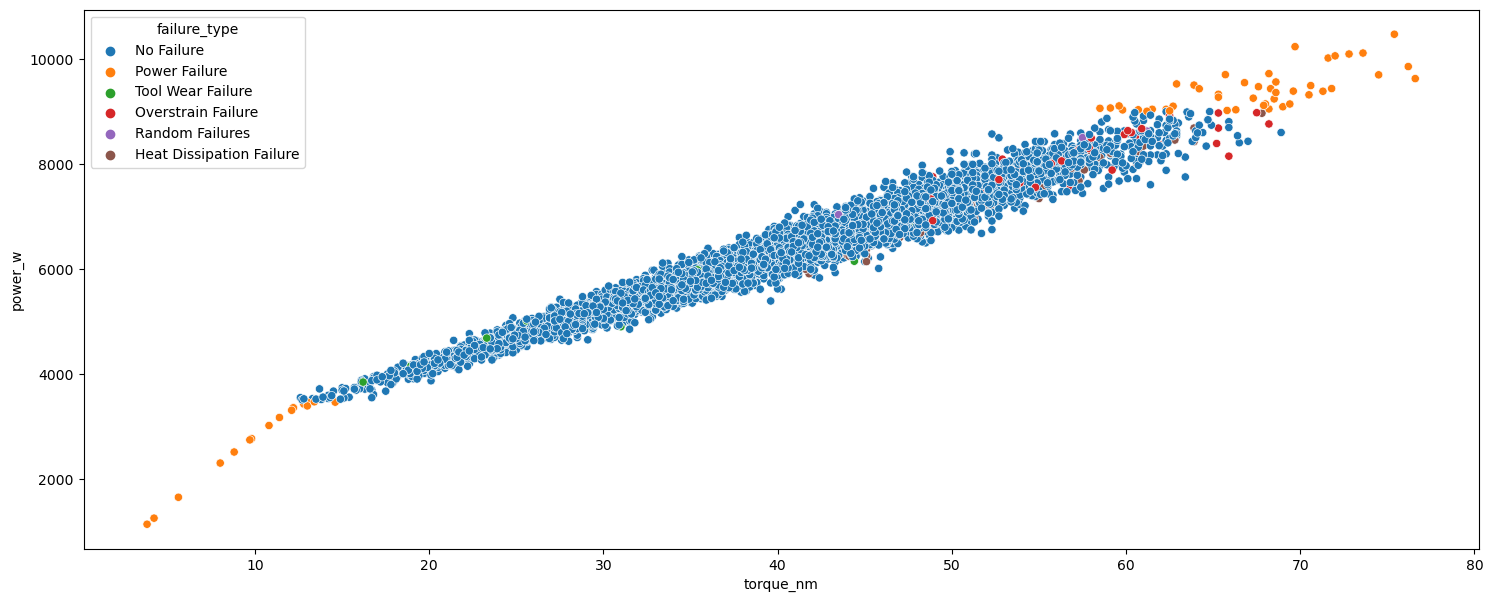

In [12]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=df1, x="torque_nm", y="power_w", hue='failure_type',palette="tab10");

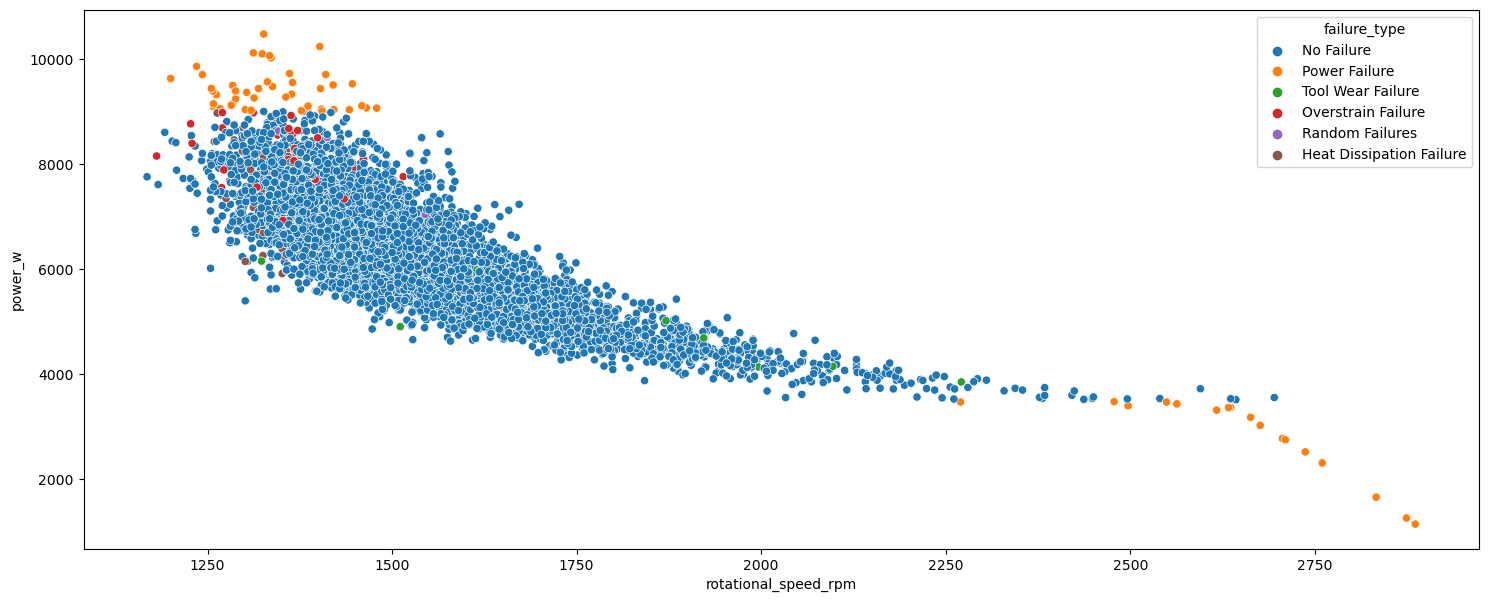

In [13]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=df1, x="rotational_speed_rpm", y="power_w", hue='failure_type',palette="tab10");

Muito interessante! Nesses plots podemos ver que há um padrão para a ocorrência do modo de falha 'power failure', corroborando a hipótese levantada de que a maior incidência desse tipo de falha ocorreria nos extremos. Será que existe relação com algum tipo dos três produtos?

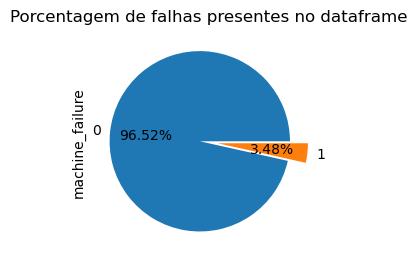

In [14]:
ax =plt.subplot(1,2,2)
ax=df1['machine_failure'].value_counts().plot.pie(explode=[0.1, 0.1],autopct='%1.2f%%');
ax.set_title(label = "Porcentagem de falhas presentes no dataframe");

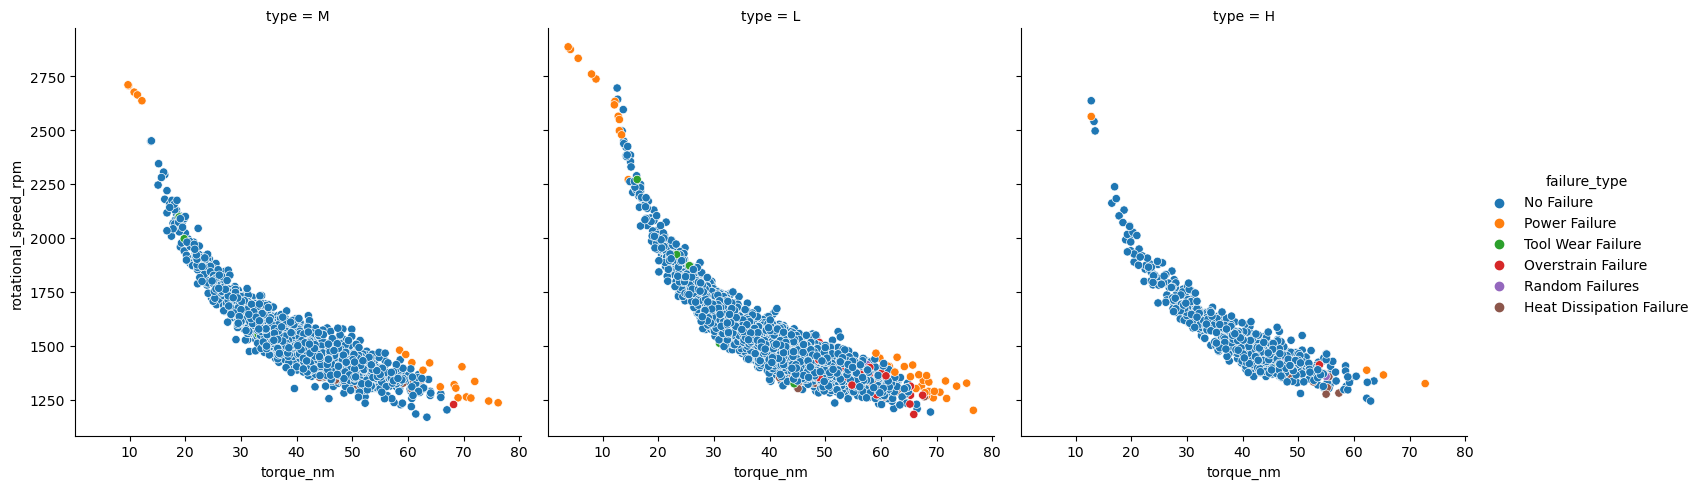

In [15]:
sns.relplot(data=df1, x="torque_nm", y="rotational_speed_rpm", hue="failure_type",col="type",palette='tab10');

Agora, com o mesmo plot entre as features 'torque_nm' e 'rotational_speed_rpm', porém discretizado por tipo de produto, podemos observar uma baixa frequência desse tipo de falha para o tipo = H.

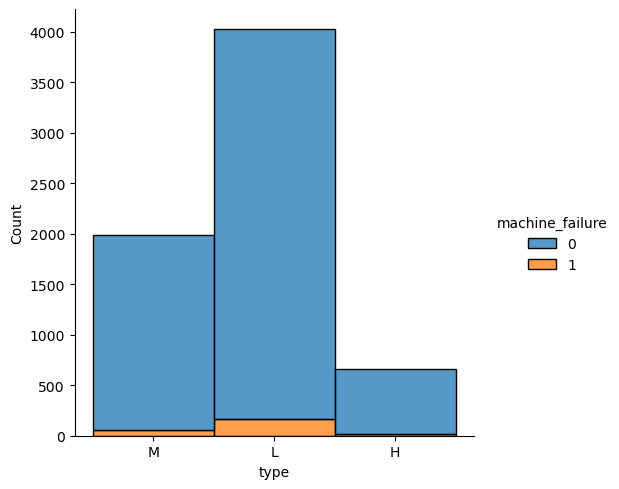

In [16]:
sns.displot(df1,x='type',hue='machine_failure', multiple="stack")

Aprofundando na investigação da relação de ocorrência de falhas por tipo de produto, optei também por plotar um gráfico de colunas para elucidar essa questão. Realmente a maior incidência de falhas reside no produto do tipo 'L', enquanto o produto do tipo 'H' apresenta a menor frequência de ocorrência de falhas.

# Pré-Processamento

In [17]:
import category_encoders as ce
encoder = ce.OrdinalEncoder(cols=['type','failure_type'])
df1 = encoder.fit_transform(df1)

from sklearn.preprocessing import LabelEncoder
scaler = LabelEncoder()
df1['failure_type'] = scaler.fit_transform(df1['failure_type'])
df1.sample(15)

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,temperature_diference_k,power_w,machine_failure
5039,7570,L54749,2,300.2,311.0,1255,71.8,149,1,10.8,9436.192403,1
5216,7836,L55015,2,300.1,311.5,1549,34.7,189,0,11.4,5628.718247,0
6087,9141,L56320,2,297.5,308.5,1373,39.9,110,0,11.0,5736.830922,0
2117,3140,H32553,3,300.4,309.9,1513,38.7,76,0,9.5,6131.666286,0
6464,9700,L56879,2,298.8,309.8,1508,36.3,69,0,11.0,5732.401277,0
3100,4635,L51814,2,303.0,311.2,1755,30.4,205,0,8.2,5587.008369,0
6662,9995,L57174,2,298.8,308.3,1634,27.9,12,0,9.5,4774.027023,0
6625,9944,M24803,1,298.3,308.0,1766,26.0,96,0,9.7,4808.312271,0
1488,2234,L49413,2,299.5,308.7,2549,13.0,179,1,9.2,3470.098521,1
2055,3041,L50220,2,300.3,309.5,1474,38.7,35,0,9.2,5973.612760,0


Nesta etapa, foi feita a codificação dos tipos de produto, que compões a feature categórica do dataset, e também da feature de prediuçaõ 'failure_type', para preparar os dados para a aplicação dos algoritmos de classificação.

In [18]:
x = df1.drop(columns=['failure_type', 'udi','product_id'])
#Excluindo de x a variável de predição, as features de enumeração de registros 
y = df1['failure_type']
x
#Separação entre preditores e variável de predição

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,temperature_diference_k,power_w,machine_failure
0,1,298.1,308.6,1551,42.8,0,10.5,6951.590552,0
1,2,298.2,308.7,1408,46.3,3,10.5,6826.722716,0
2,2,298.2,308.7,1408,40.0,9,10.5,5897.816602,0
3,1,298.1,308.6,1425,41.9,11,10.5,6252.554772,0
4,2,298.1,308.6,1558,42.4,14,10.5,6917.703239,0
...,...,...,...,...,...,...,...,...,...
6662,2,298.8,308.3,1634,27.9,12,9.5,4774.027023,0
6663,1,298.8,308.4,1604,29.5,14,9.6,4955.129367,0
6664,3,298.9,308.4,1632,31.8,17,9.5,5434.703957,0
6665,3,299.0,308.7,1408,48.5,25,9.7,7151.102629,0


# Primeiro split dos dados

Nesta etapa, inicialmente separamos o dataset (split) em 70% trieno e 30% teste.

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3, random_state = 6)

In [20]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

X_train = pd.DataFrame(minmax.fit_transform(X_train), columns = x.columns)
X_test = pd.DataFrame(minmax.fit_transform(X_test), columns = x.columns)
X_train

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,temperature_diference_k,power_w,machine_failure
0,0.5,0.260870,0.185185,0.293083,0.466667,0.019920,0.422222,0.579909,0.0
1,0.5,0.282609,0.259259,0.291325,0.412500,0.406375,0.511111,0.504754,0.0
2,1.0,0.902174,0.851852,0.193435,0.500000,0.617530,0.311111,0.547708,0.0
3,0.0,0.250000,0.296296,0.123681,0.738889,0.486056,0.644444,0.763100,0.0
4,1.0,0.619565,0.543210,0.344666,0.368056,0.007968,0.333333,0.475925,0.0
...,...,...,...,...,...,...,...,...,...
4661,0.0,0.228261,0.407407,0.303048,0.368056,0.705179,0.888889,0.451130,0.0
4662,0.5,0.586957,0.592593,0.464244,0.233333,0.772908,0.488889,0.330899,0.0
4663,0.0,0.586957,0.469136,0.131887,0.551389,0.322709,0.266667,0.558322,0.0
4664,0.5,0.260870,0.345679,0.120164,0.729167,0.808765,0.711111,0.748249,1.0


Antes de prosseguir para o treinamento do modelo, é necessário normalizar os dados, para que não haja risco de não convergência do modelo, uma vez que os data points das features numéricas possuem parêmtros muito diferentes de escala. A noramlização, portanto, serve para trazer os valores das colunas numéricas para uma base comum enquanto respeita a diferença nos intervalos de valores, evitando distorções.

O método MinMaxScaler foi escolhido de acordo com a característica das features: o método aplica um cálculo de reescala independente para cada feature, variando entre 0 e 1 (quando não há features negativas, como em nosso caso). O método MinMaxScalker preserva a distribuição dos dados originais.

Como as variáveis categóricas já estão codificadas e as variáveis numéricas já estão normalizados (mesma escala), segue-se para o treino do modelo.

# Regressão Logística

Acurácia:  99.3 % 

Relatório de Classificação: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1931
           1       0.92      0.73      0.81        15
           2       0.88      0.70      0.78        10
           3       0.72      0.81      0.76        16
           4       0.00      0.00      0.00         4
           5       0.78      1.00      0.88        25

    accuracy                           0.99      2001
   macro avg       0.72      0.71      0.71      2001
weighted avg       0.99      0.99      0.99      2001



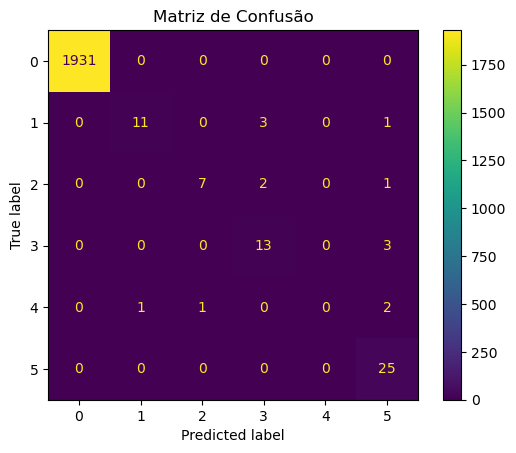

In [21]:
from sklearn.linear_model import LogisticRegression #Importação do algortimo de Regressão Logística Utilizado
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
#Importação das métricsas utilizadas para verificação de convergência do modelo 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #Por questões visuais, resolvi esconder as warnings

lr=LogisticRegression() #Modelo
lr.fit(X_train, y_train) #Treinando o modelo

predictions=lr.predict(X_test)
score=accuracy_score(y_test,predictions)
score_percent = score * 100
print("Acurácia: ", round(score_percent,2),"% \n")
plot_confusion_matrix(lr, X_test, y_test);
plt.title('Matriz de Confusão')
print("Relatório de Classificação: \n",classification_report(y_test,predictions, zero_division = 0))

# Random Forest

Acurácia:  99.5 % 

Relatório de Classificação: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1931
           1       0.65      1.00      0.79        15
           2       1.00      0.90      0.95        10
           3       0.89      0.50      0.64        16
           4       1.00      0.75      0.86         4
           5       0.96      1.00      0.98        25

    accuracy                           1.00      2001
   macro avg       0.92      0.86      0.87      2001
weighted avg       1.00      1.00      0.99      2001



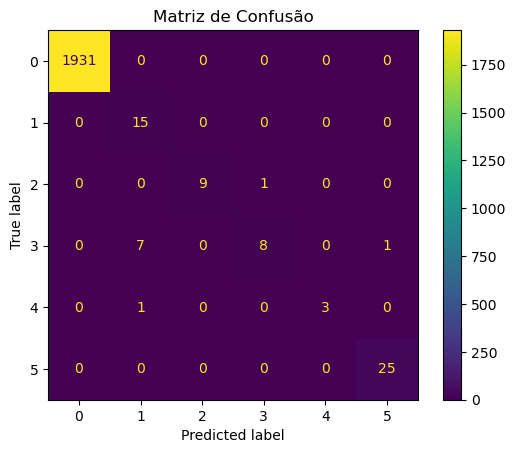

In [22]:
from sklearn.ensemble import RandomForestClassifier #Importação do algortimo de Random Forest Utilizado

rfc=RandomForestClassifier() 
rfc.fit(X_train,y_train)
predictions=rfc.predict(X_test)
score=accuracy_score(y_test,predictions)
score_percent = score * 100
print("Acurácia: ", round(score_percent,3),"% \n")
plot_confusion_matrix(rfc, X_test, y_test);
plt.title('Matriz de Confusão')
print("Relatório de Classificação: \n",classification_report(y_test,predictions, zero_division = 0))

# Decision Tree

Acurácia:  99.5 % 

Relatório de Classificação: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1931
           1       0.65      1.00      0.79        15
           2       1.00      0.90      0.95        10
           3       0.89      0.50      0.64        16
           4       1.00      0.75      0.86         4
           5       0.96      1.00      0.98        25

    accuracy                           1.00      2001
   macro avg       0.92      0.86      0.87      2001
weighted avg       1.00      1.00      0.99      2001



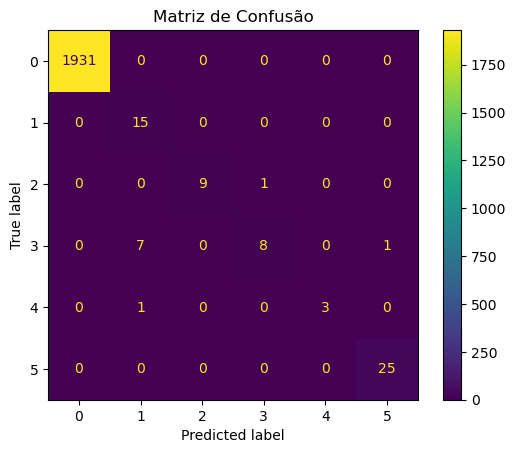

In [23]:
from sklearn.tree import DecisionTreeClassifier #Importação do algortimo de Decision Tree Utilizado
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
predictions=dt.predict(X_test)
score=accuracy_score(y_test,predictions)
score_percent = score * 100
print("Acurácia: ", round(score_percent,3),"% \n")
plot_confusion_matrix(dt, X_test, y_test);
plt.title('Matriz de Confusão')
print("Relatório de Classificação: \n",classification_report(y_test,predictions, zero_division = 0))

# XGBoost

Acurácia:  99.5 % 

Relatório de Classificação: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1931
           1       0.65      1.00      0.79        15
           2       1.00      0.90      0.95        10
           3       0.89      0.50      0.64        16
           4       1.00      0.75      0.86         4
           5       0.96      1.00      0.98        25

    accuracy                           1.00      2001
   macro avg       0.92      0.86      0.87      2001
weighted avg       1.00      1.00      0.99      2001



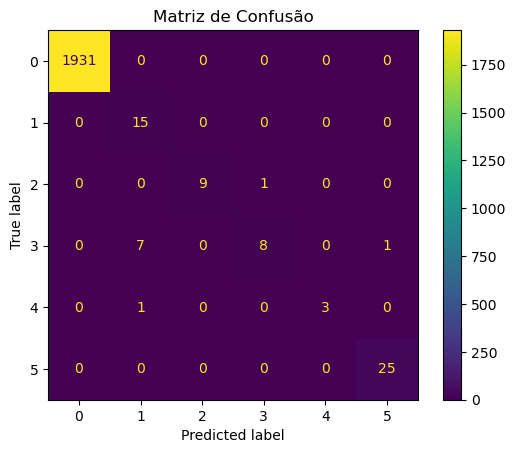

In [24]:
from xgboost import XGBClassifier #Importação do algortimo de GXBoost
bst=XGBClassifier(n_estimators=6, max_depth=2, learning_rate=1, objective='binary:logistic') 
#Justificativa dos parâmetros do modelo: n_estimators = 6: número de estimadores na feature 'failure_type', os 5 modos de falha
#mais a ausência de falha. Os outros parâmetros são recomendações encontradas na documentação do modelo.
bst.fit(X_train,y_train) 
predictions=bst.predict(X_test)
score=accuracy_score(y_test,predictions)
score_percent = score * 100
print("Acurácia: ", round(score_percent,3),"% \n")
plot_confusion_matrix(bst, X_test, y_test);
plt.title('Matriz de Confusão')
print("Relatório de Classificação: \n",classification_report(y_test,predictions, zero_division = 0))

# Naive Bayes

Acurácia:  99.5 % 

Relatório de Classificação XGBoost: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1931
           1       0.67      0.93      0.78        15
           2       0.88      0.70      0.78        10
           3       0.93      0.81      0.87        16
           4       0.00      0.00      0.00         4
           5       0.93      1.00      0.96        25

    accuracy                           0.99      2001
   macro avg       0.73      0.74      0.73      2001
weighted avg       0.99      0.99      0.99      2001



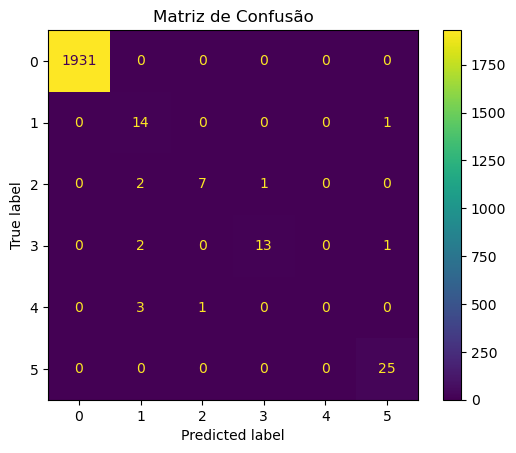

In [25]:
from sklearn.naive_bayes import GaussianNB  #Importação do algortimo de GXBoost
gnb=GaussianNB()
gnb.fit(X_train,y_train) 
predictions_gnb=gnb.predict(X_test)
score=accuracy_score(y_test,predictions)
score_percent = score * 100
print("Acurácia: ", round(score_percent,3),"% \n")
plot_confusion_matrix(gnb, X_test, y_test);
plt.title('Matriz de Confusão')
print("Relatório de Classificação XGBoost: \n",classification_report(y_test,predictions_gnb, zero_division = 0))

# ADA Boost

Acurácia:  98.401 % 

Relatório de Classificação ADA Boost: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1931
           1       0.33      0.87      0.47        15
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         4
           5       0.83      1.00      0.91        25

    accuracy                           0.98      2001
   macro avg       0.36      0.48      0.40      2001
weighted avg       0.98      0.98      0.98      2001



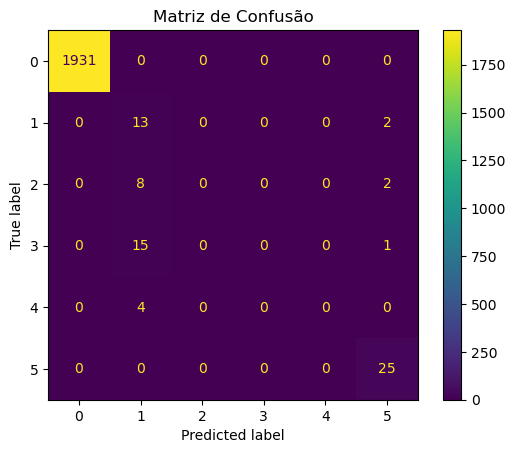

In [26]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=6, learning_rate=1)
clf.fit(X_train,y_train) 
predictions_clf=clf.predict(X_test)
score=accuracy_score(y_test,predictions_clf)
score_percent = score * 100
print("Acurácia: ", round(score_percent,3),"% \n")
plot_confusion_matrix(clf, X_test, y_test);
plt.title('Matriz de Confusão')
print("Relatório de Classificação ADA Boost: \n",classification_report(y_test,predictions_clf, zero_division = 0))

Muito bom! Conseguimos de cara uma acurácia de 99% apenas com a codificação (encoder) e normalização dos dados (data normalization). A ideia inicial era a utilização de algortimos de seleção de features, como por exemplo o RFE (Recursive Feature Elimination): utilizado em datasets com baixa dimensionalidade, como em nosso caso. Mas como já obtivemos uma acurácia satisfatória, preferi seguir adiante. Mas antes de decidir qual modelo utilizar, gostaria de explorar outras métricas.

Se variarmos a proporção de split do dataset em treino e teste para 50/50, será que a acurácia apresentada se mantém? É esperado que os modelos apresentem um valor menor quando apresentamos menos registros para treinos. Entretanto, se a diferença não for significativa, isso já nos mostra que grandes são as chaces do modelo estar robusto.

In [27]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.5, random_state = 6) #Split e normalização
X_train = pd.DataFrame(minmax.fit_transform(X_train), columns = x.columns)
X_test = pd.DataFrame(minmax.fit_transform(X_test), columns = x.columns)
X_train

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,temperature_diference_k,power_w,machine_failure
0,0.0,0.739130,0.666667,0.157895,0.665730,0.342629,0.311111,0.713792,0.0
1,0.5,0.728261,0.679012,0.051449,0.858146,0.725100,0.355556,0.806058,1.0
2,0.5,0.554348,0.481481,0.201064,0.481742,0.494024,0.355556,0.529688,0.0
3,0.0,0.891304,0.888889,0.230041,0.568820,0.334661,0.400000,0.662016,0.0
4,0.5,0.913043,0.913580,0.101715,0.630618,0.749004,0.400000,0.619497,0.0
...,...,...,...,...,...,...,...,...,...
3328,0.0,0.228261,0.407407,0.296866,0.372191,0.705179,0.888889,0.451130,0.0
3329,0.5,0.586957,0.592593,0.459491,0.235955,0.772908,0.488889,0.330899,0.0
3330,0.0,0.586957,0.469136,0.124187,0.557584,0.322709,0.266667,0.558322,0.0
3331,0.5,0.260870,0.345679,0.112360,0.737360,0.808765,0.711111,0.748249,1.0


# Regressão Logística - Segundo Split

Acurácia:  99.16 % 

Relatório de Classificação Regressão Logística: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3221
           1       0.90      0.59      0.72        32
           2       0.75      0.69      0.72        13
           3       0.71      0.80      0.75        25
           4       0.00      0.00      0.00         6
           5       0.71      1.00      0.83        37

    accuracy                           0.99      3334
   macro avg       0.68      0.68      0.67      3334
weighted avg       0.99      0.99      0.99      3334



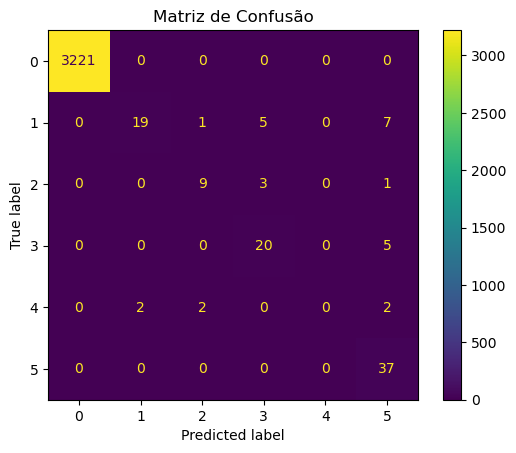

In [28]:
lr=LogisticRegression()
lr.fit(X_train, y_train)
predictions_lr=lr.predict(X_test)
score=accuracy_score(y_test,predictions_lr)
score_percent = score * 100
print("Acurácia: ", round(score_percent,2),"% \n")
plot_confusion_matrix(lr, X_test, y_test);
plt.title('Matriz de Confusão')
print("Relatório de Classificação Regressão Logística: \n",classification_report(y_test,predictions_lr, zero_division = 0))

# Random Forest - Segundo Split

Acurácia:  97.54 %
Relatório de Classificação Random Forest: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3221
           1       0.89      0.97      0.93        32
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        37

    accuracy                           0.98      3334
   macro avg       0.31      0.33      0.32      3334
weighted avg       0.95      0.98      0.96      3334



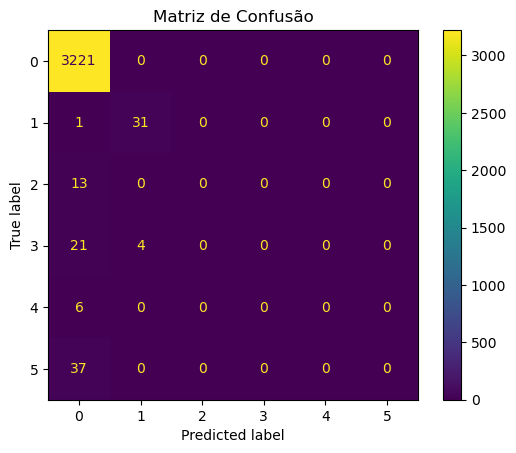

In [29]:
rfc=RandomForestClassifier(max_depth=2, random_state=0) 
rfc.fit(X_train,y_train)
predictions_rf=rfc.predict(X_test)
score=accuracy_score(y_test,predictions_rf)
score_percent = score * 100
print("Acurácia: ", round(score_percent,3),"%")
plot_confusion_matrix(rfc, X_test, y_test);
plt.title('Matriz de Confusão')
print("Relatório de Classificação Random Forest: \n",classification_report(y_test,predictions_rf, zero_division = 0))

 # Decision Tree - Segundo Split

Acurácia:  99.64 %
Relatório de Classificação Decision Tree: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3221
           1       0.83      0.94      0.88        32
           2       0.86      0.92      0.89        13
           3       0.86      0.72      0.78        25
           4       1.00      0.67      0.80         6
           5       0.97      1.00      0.99        37

    accuracy                           1.00      3334
   macro avg       0.92      0.87      0.89      3334
weighted avg       1.00      1.00      1.00      3334



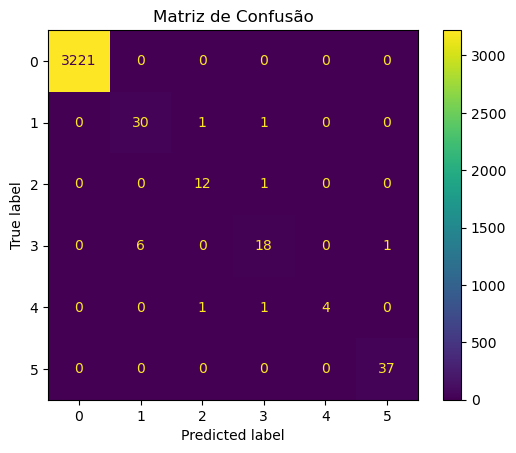

In [30]:
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
predictions_dt=dt.predict(X_test)
score=accuracy_score(y_test,predictions_dt)
score_percent = score * 100
print("Acurácia: ", round(score_percent,3),"%")
plot_confusion_matrix(dt, X_test, y_test);
plt.title('Matriz de Confusão')
print("Relatório de Classificação Decision Tree: \n",classification_report(y_test,predictions_dt, zero_division = 0))

# XG Boost - Segundo Split

Acurácia:  99.73 % 

Relatório de Classificação XGBoost: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3221
           1       0.88      0.94      0.91        32
           2       0.86      0.92      0.89        13
           3       0.95      0.84      0.89        25
           4       0.71      0.83      0.77         6
           5       1.00      0.97      0.99        37

    accuracy                           1.00      3334
   macro avg       0.90      0.92      0.91      3334
weighted avg       1.00      1.00      1.00      3334



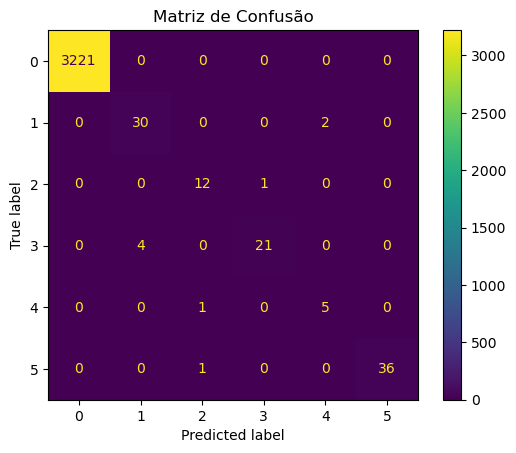

In [31]:
bst=XGBClassifier(n_estimators=6, max_depth=2, learning_rate=1, objective='binary:logistic') 
bst.fit(X_train,y_train) 
predictions_bst=bst.predict(X_test)
score=accuracy_score(y_test,predictions_bst)
score_percent = score * 100
print("Acurácia: ", round(score_percent,3),"% \n")
plot_confusion_matrix(bst, X_test, y_test);
plt.title('Matriz de Confusão')
print("Relatório de Classificação XGBoost: \n",classification_report(y_test,predictions_bst, zero_division = 0))

# Naive Bayes - Segundo Split

Acurácia:  99.55 % 

Relatório de Classificação Naive Bayes: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3221
           1       0.78      0.88      0.82        32
           2       0.91      0.77      0.83        13
           3       0.92      0.88      0.90        25
           4       0.50      0.17      0.25         6
           5       0.93      1.00      0.96        37

    accuracy                           1.00      3334
   macro avg       0.84      0.78      0.79      3334
weighted avg       1.00      1.00      1.00      3334



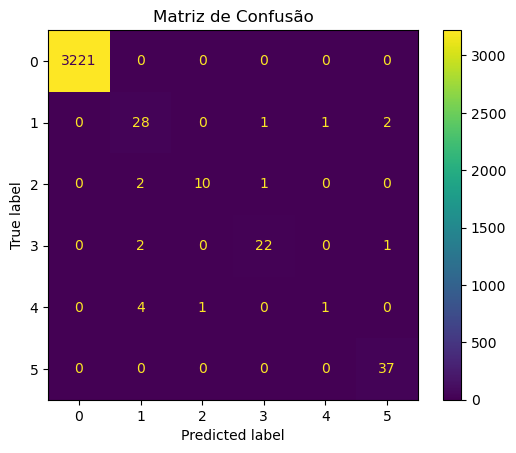

In [32]:
gnb=GaussianNB()
gnb.fit(X_train,y_train) 
predictions_gnb=gnb.predict(X_test)
score=accuracy_score(y_test,predictions_gnb)
score_percent = score * 100
print("Acurácia: ", round(score_percent,3),"% \n")
plot_confusion_matrix(gnb, X_test, y_test);
plt.title('Matriz de Confusão')
print("Relatório de Classificação Naive Bayes: \n",classification_report(y_test,predictions_gnb, zero_division = 0))

# ADA Boost - Segundo Split

Acurácia:  99.13 % 

Relatório de Classificação ADA Boost: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3221
           1       0.76      0.81      0.79        32
           2       0.00      0.00      0.00        13
           3       0.58      0.84      0.69        25
           4       0.00      0.00      0.00         6
           5       0.86      1.00      0.92        37

    accuracy                           0.99      3334
   macro avg       0.53      0.61      0.57      3334
weighted avg       0.99      0.99      0.99      3334



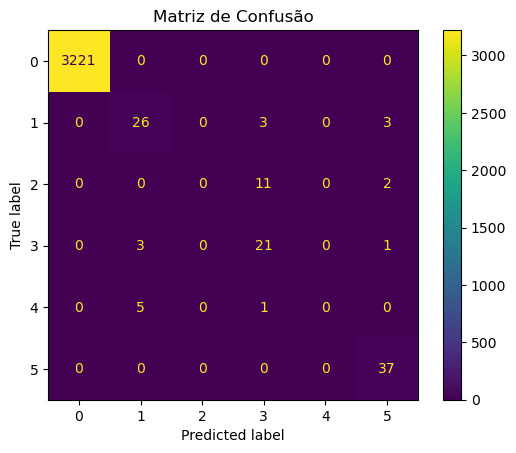

In [33]:
clf = AdaBoostClassifier(n_estimators=6, learning_rate=1)
clf.fit(X_train,y_train) 
predictions_clf=clf.predict(X_test)
score=accuracy_score(y_test,predictions_clf)
score_percent = score * 100
print("Acurácia: ", round(score_percent,3),"% \n")
plot_confusion_matrix(clf, X_test, y_test);
plt.title('Matriz de Confusão')
print("Relatório de Classificação ADA Boost: \n",classification_report(y_test,predictions_clf, zero_division = 0))

# Análise de performance e escolha de modelo

In [34]:
print("Relatório de Classificação Regressão Logística: \n",classification_report(y_test,predictions_lr, zero_division = 0), "\n")
print("Relatório de Classificação Random Forest: \n",classification_report(y_test,predictions_rf, zero_division = 0),"\n")
print("Relatório de Classificação Decision Tree: \n",classification_report(y_test,predictions_dt, zero_division = 0), "\n")
print("Relatório de Classificação XGBoost: \n",classification_report(y_test,predictions_bst, zero_division = 0), "\n")
print("Relatório de Classificação Naive Bayes: \n",classification_report(y_test,predictions_gnb, zero_division = 0), "\n")
print("Relatório de Classificação ADA Boost: \n",classification_report(y_test,predictions_clf, zero_division = 0))

Relatório de Classificação Regressão Logística: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3221
           1       0.90      0.59      0.72        32
           2       0.75      0.69      0.72        13
           3       0.71      0.80      0.75        25
           4       0.00      0.00      0.00         6
           5       0.71      1.00      0.83        37

    accuracy                           0.99      3334
   macro avg       0.68      0.68      0.67      3334
weighted avg       0.99      0.99      0.99      3334
 

Relatório de Classificação Random Forest: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3221
           1       0.89      0.97      0.93        32
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00         6
           5       0.00      0.00   

As medidas de performance escolhidas para avaliar os modelos foram as métricas de acurácia (accuracy), a precisão (precision), o recall (revocação) e o f1-score. São métricas usualmente utilizadas para avaliar modelos em problemas de classificação multi-classe, como o nosso em questão.

Tudo começa com a acurácia e a matriz de confusão. A acurácia, por si só, constitui a razão do números de acerto das previsões pelo total de previsões feitas. É um indicador que pode ser utilizado para ter algumas noções iniciais para escolha do modelo, pois um bom modelo necessariamente terá uma alta acurácia; mas não é indicado dar o veridito final apenas com a comparação de modelos por este indicador. E o porque disso? Justamente o que ocorre neste dataset: uma acurácia alta pode mascarar um baixo grau de acerto em problemas de multiclasse quando as distintas categorias da variável de predição apresentam diferentes frequências na feature de predição.

Recapitulando:

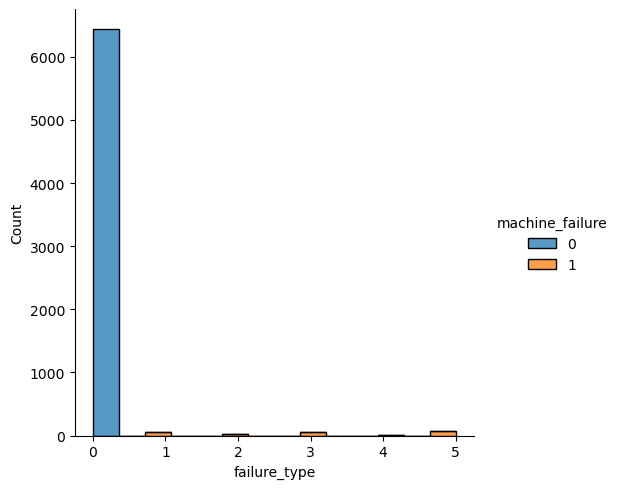

In [35]:
sns.displot(df1,x='failure_type',hue='machine_failure', multiple="stack")

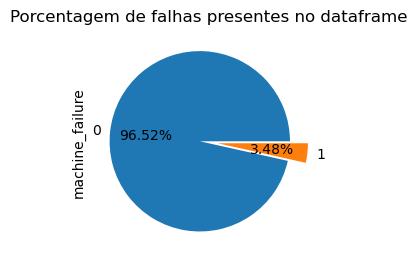

In [36]:
ax =plt.subplot(1,2,2)
ax=df1['machine_failure'].value_counts().plot.pie(explode=[0.1, 0.1],autopct='%1.2f%%');
ax.set_title(label = "Porcentagem de falhas presentes no dataframe");

Em nosso dataset, a quantidade de registros de falhas de máquinas são muito pequenas quando comparadas ao todo, o que poderia ocasionar, independente do split, o treinamento de um modelo com alta acurácia de predição (pois acerta bastantes pontos de não-falha) mas com deficiência em prever o tipo de falha, que é o objetivo final da produção deste modelo.

Sendo assim, entende-se que o indicador de acurácia não é o suficente. Para suprir este déficit gerei a matriz de confusão para cada modelo, que, por sua vez, gera as informações necessárias para a apuração dos indicadores que utilizaremos.

Os indicadores principais são a precisão (precision) e a revocação (recall). De maneira simplória, a precisão da uma ênfase maior para os erros de falso positivo (das falhas de máquina que o modelo preveu, quais realmente são falhas?).

A revocação (recall), por sua vez, é utilizada em situações onde o falso negativo é mais custoso (das falhas de máquina que o modelo preveu, quantas falhas de máquina o modelo deixou passar?). Um indicador adjacente é o F1-Score, compondo a média harmônica da revocação com a precisão.

Nesta linha de raciocínio, devemos pensar: qual tipo de erro de um modelo nos seria mais custoso? Um falto-positivo, correspondendo a um desperdício de realizar manutenção em uma máquina que não apresentaria falhas, ou um falso negativo, que falharia em prever uma quebra de máquina? É evidente que o falso negativo é mais custoso, sendo assim o recall o nosso principal indicador, seguido da acurácia dos modelos.

Para a escolha do modelo, então, foi utilizado o maior valor de recall (mais próximo de 1), seguido da acurácia como critério de desempate. 

In [37]:
print("Relatório de Classificação XGBoost: \n",classification_report(y_test,predictions_bst, zero_division = 0), "\n")

Relatório de Classificação XGBoost: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3221
           1       0.88      0.94      0.91        32
           2       0.86      0.92      0.89        13
           3       0.95      0.84      0.89        25
           4       0.71      0.83      0.77         6
           5       1.00      0.97      0.99        37

    accuracy                           1.00      3334
   macro avg       0.90      0.92      0.91      3334
weighted avg       1.00      1.00      1.00      3334
 



Sendo assim, o algoritmo escolhido foi o ensemble XGBoost, que possui uma média geral de 0,92 de recall e uma acurácia de aproximadamente 100%. 

# Predição

In [38]:
df2.head(5)

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,446,L47625,L,297.5,308.6,1793,26.7,70
1,7076,L54255,L,300.7,310.5,1536,47.4,192
2,1191,L48370,L,297.2,308.4,1460,42.1,41
3,2618,L49797,L,299.4,309.1,1670,35.9,68
4,5067,L52246,L,304.1,313.1,1550,30.9,9


Antes da predição, é necessário realizar as transformações no dataset de teste tais quais foram feitas no dataset de treino, antes de alimentar o modelo.

Vamos então calcular as features adicionais criadas, remover as features que não contribuem no modelo, codificar as variáveis categóricas e, por fim, normalizar as features numéricas.

In [39]:
#Cálculo de colunas adicionais criadas

df2["temperature_diference_k"] = df2["process_temperature_k"] - df2["air_temperature_k"]
df2['power_w'] = df2['torque_nm'] * (df2['rotational_speed_rpm']/9.5492965964254) #conversão de rpm para rad/s
df2.sample(15)

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,temperature_diference_k,power_w
1218,9798,M24657,M,298.4,309.2,1597,33.5,116,10.8,5602.454533
1111,187,L47366,L,298.1,308.3,1301,56.0,63,10.2,7629.462470
1439,6324,L53503,L,300.7,310.1,1351,46.9,165,9.4,6635.242644
2562,2387,L49566,L,299.1,308.4,1543,37.9,130,9.3,6123.979856
1380,3523,L50702,L,301.8,311.0,1651,32.5,195,9.2,5619.000254
608,6254,L53433,L,300.9,310.4,1615,30.9,200,9.5,5225.882294
2258,2166,L49345,L,299.5,309.1,1476,47.8,223,9.6,7388.271931
2942,6310,L53489,L,300.9,310.2,1382,50.4,131,9.3,7294.024151
486,5613,L52792,L,303.0,312.3,1486,42.4,112,9.3,6598.014771
1862,5540,H34953,H,302.3,311.7,1482,39.0,127,9.4,6052.592399


In [40]:
X_test = df2.drop(columns=['udi','product_id']) #Excluindo as features de identificação de registros
X_test

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,temperature_diference_k,power_w
0,L,297.5,308.6,1793,26.7,70,11.1,5013.259303
1,L,300.7,310.5,1536,47.4,192,9.8,7624.268370
2,L,297.2,308.4,1460,42.1,41,11.2,6436.704461
3,L,299.4,309.1,1670,35.9,68,9.7,6278.263472
4,L,304.1,313.1,1550,30.9,9,9.0,5015.552666
...,...,...,...,...,...,...,...,...
3328,L,302.5,311.9,1306,59.7,172,9.4,8164.810802
3329,L,300.7,311.0,1413,52.0,91,10.3,7694.388718
3330,L,300.8,311.2,1481,38.5,181,10.4,5970.963350
3331,L,302.8,312.2,1509,36.5,52,9.4,5767.807026


In [41]:
from itertools import product


lst = []


for temp, rad, power, types, tool, torque in zip(
    X_test['temperature_diference_k'], 
    X_test['rotational_speed_rpm'], 
    X_test['power_w'], df['type'],
    X_test['tool_wear_min'],
    X_test['torque_nm']):
  
    if temp < 8 and rad <1380:
        machine_failure = 1
    elif power > 9000 or power < 3500:
        machine_failure = 1
    elif types == "L" and torque * tool>= 11000:
        machine_failure = 1 
    elif types == "M" and torque * tool>= 12000:
        machine_failure = 1
      
    elif types == "H" and torque * tool>= 13000:
        machine_failure = 1 
    else:
        machine_failure = 0
    lst.append(machine_failure)

X_test['machine_failure'] = lst

In [42]:
X_test

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,temperature_diference_k,power_w,machine_failure
0,L,297.5,308.6,1793,26.7,70,11.1,5013.259303,0
1,L,300.7,310.5,1536,47.4,192,9.8,7624.268370,0
2,L,297.2,308.4,1460,42.1,41,11.2,6436.704461,0
3,L,299.4,309.1,1670,35.9,68,9.7,6278.263472,0
4,L,304.1,313.1,1550,30.9,9,9.0,5015.552666,0
...,...,...,...,...,...,...,...,...,...
3328,L,302.5,311.9,1306,59.7,172,9.4,8164.810802,0
3329,L,300.7,311.0,1413,52.0,91,10.3,7694.388718,0
3330,L,300.8,311.2,1481,38.5,181,10.4,5970.963350,0
3331,L,302.8,312.2,1509,36.5,52,9.4,5767.807026,0


In [43]:
#Codificação de features categóricas

encoder = ce.OrdinalEncoder(cols=['type']) 
X_test = encoder.fit_transform(X_test)
X_test.sample(5)

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,temperature_diference_k,power_w,machine_failure
1840,1,300.1,311.5,1434,40.8,80,11.4,6126.859650,0
2458,2,300.8,310.2,1304,52.5,157,9.4,7169.114427,0
1857,3,296.7,307.5,1607,33.6,38,10.8,5654.364115,0
1435,2,300.3,310.0,1537,37.5,6,9.7,6035.784879,0
1107,2,298.4,309.5,1344,45.3,122,11.1,6375.673788,0


In [50]:
#Realizando predição

bst=XGBClassifier(n_estimators=6, max_depth=2, learning_rate=1, objective='binary:logistic') 
bst.fit(X_train,y_train) 
predictions_machine_failure_type=bst.predict(X_test)
predictions_machine_failure_type = pd.DataFrame(predictions_machine_failure_type, columns=["predictedValues"])
predictions_machine_failure_type

,predictedValues
0,0
1,0
2,0
3,0
4,0
...,...
3328,0
3329,0
3330,0
3331,0


In [53]:
result = predictions_machine_failure_type[['predictedValues']]

,predictedValues
0,0
1,0
2,0
3,0
4,0
...,...
3328,0
3329,0
3330,0
3331,0


In [52]:
#Exportando arquivo .csv final
result.to_csv('predicted.csv', index=True,index_label='rowNumber')